In [5]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import imageio

import torch
from torchvision import transforms
from torch.utils.data import DataLoader

from model2 import MergeNN
from config import get_configs
from dloader2 import HDRDataset

In [2]:
args = get_configs()

input_transformer = transforms.Compose(
    [transforms.Resize(args.insize),
     transforms.ToTensor()])

output_transformer = transforms.Compose(
    [transforms.ToTensor()])

train_dataset = HDRDataset(args.train_ds_path, "train", args.train_xsl_path, args.outsize, args.insize, input_transformer,
                           output_transformer, flip_prob=0.5)
train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True)
device = torch.device(f'cuda:{0}' if torch.cuda.is_available() else 'cpu')

In [3]:
model = MergeNN()
saved_dict = torch.load( f'model_1.pt')
model.load_state_dict(saved_dict['model_state_dict'])
model.to(device)
mu =torch.LongTensor([5000]).to(device)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


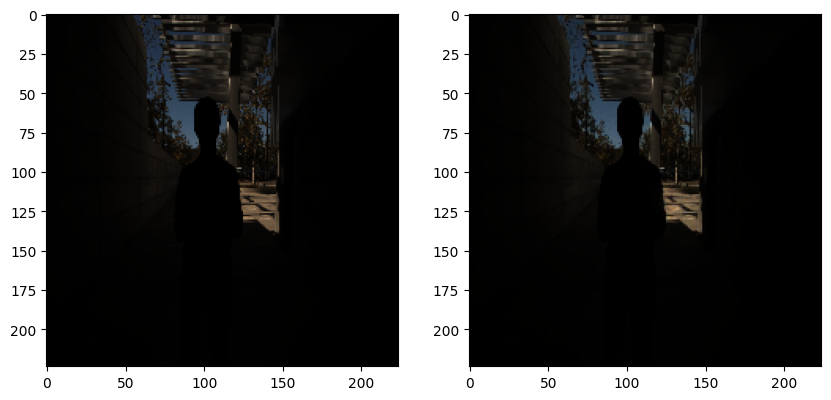

 20%|████████████████▊                                                                   | 1/5 [00:01<00:04,  1.05s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


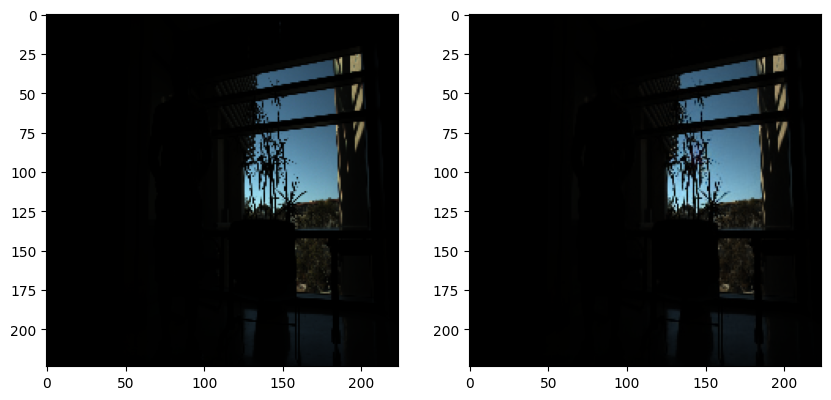

 40%|█████████████████████████████████▌                                                  | 2/5 [00:01<00:02,  1.13it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


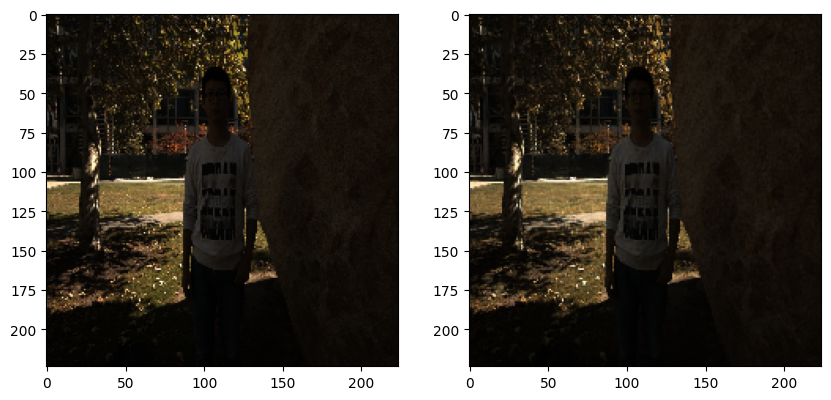

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:02<00:01,  1.09it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


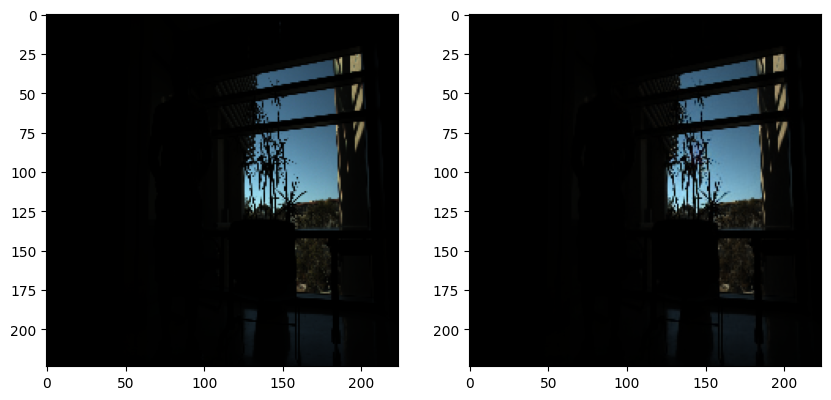

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:03<00:00,  1.19it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


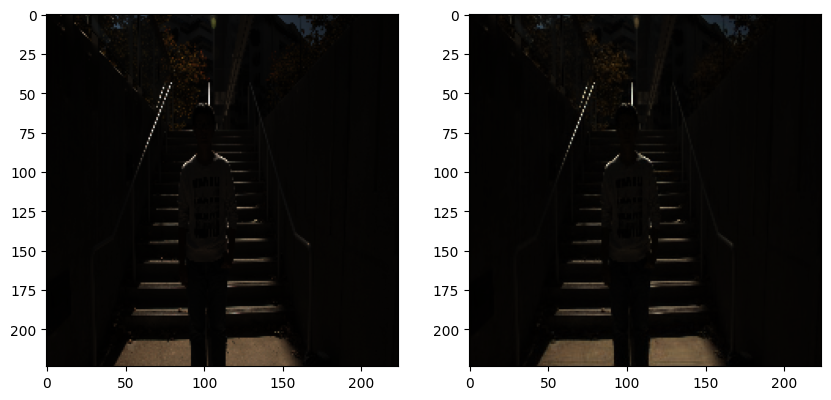

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.15it/s]


In [8]:
train_bar = tqdm(train_loader)
for i, data in enumerate(train_bar):

    H2R_x = torch.cat([data["H2R"], data["GH2R"]], dim=1).to(device)
    L2R_x = torch.cat([data["L2R"], data["GL2R"]], dim=1).to(device)
    tif1_x = torch.cat([data["TIF1"], data["GTIF1"]], dim=1).to(device)
    tif2_x = torch.cat([data["TIF2"], data["GTIF2"]], dim=1).to(device)
    tif3_x = torch.cat([data["TIF3"], data["GTIF3"]], dim=1).to(device)

    y_generated = model(H2R_x, L2R_x, tif1_x, tif2_x, tif3_x)

    log_y_generated = y_generated
    log_ground_truth = data['GT']
    
    imageio.imwrite(f'results/{i}.hdr', log_y_generated[0].permute(1,2,0).data.cpu().numpy())
    
    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(log_ground_truth[0].permute(1,2,0).data.numpy())
    plt.subplot(122)
    plt.imshow(log_y_generated[0].permute(1,2,0).data.cpu().numpy())
    plt.show()